# Подключение бибилиотек

In [2]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import * # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
import tensorflow as tf
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import shutil
import os # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image # импортируем модель Image для работы с изображениями
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model, save_model
import tqdm

import cv2 as cv
from PIL import Image
sns.set_style('darkgrid')

In [3]:
from google.colab import drive # Подключаем гугл-диск
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Сегментация документов

## Загрузка картинок

In [4]:
# Глобальные параметры
num_classes = 2 # Задаем количество классов на изображении
directory = '/content/drive/My Drive/segmentation/' # Указываем путь к обучающей выборке с оригинальными изображения

### Оригинальные изображения

In [5]:
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv.getPerspectiveTransform(rect, dst)
	warped = cv.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped

def get_coordinates_logic(img, factor = 100):
  color = (128, 0, 128)
  width = img.shape[1]
  height = img.shape[0]
  x_scale = width - factor + 1
  y_scale = height - factor + 1

  try:
    temp_img = img[0:factor, 0:factor, :]
    w1 = min(np.array(np.where(np.all(temp_img != color, axis=-1)))[1])
    h1 = min(np.array(np.where(np.all(temp_img != color, axis=-1)))[0])
    temp_img = img[0:factor, -factor:, :]
    w2 = max(np.array(np.where(np.all(temp_img != color, axis=-1)))[1]) + x_scale
    h2 = min(np.array(np.where(np.all(temp_img != color, axis=-1)))[0])
    temp_img = img[-factor:, -factor:, :]
    w3 = max(np.array(np.where(np.all(temp_img != color, axis=-1)))[1]) + x_scale
    h3 = max(np.array(np.where(np.all(temp_img != color, axis=-1)))[0]) + y_scale
    temp_img = img[-factor:, 0:factor, :]
    w4 = min(np.array(np.where(np.all(temp_img != color, axis=-1)))[1])
    h4 = max(np.array(np.where(np.all(temp_img != color, axis=-1)))[0]) + y_scale
  except:
    w1, w2, w3, w4, h1, h2, h3, h4 = get_coordinates_logic(img, factor = factor + 50)
  
  return w1, w2, w3, w4, h1, h2, h3, h4

def process_img(img):
  img = img.copy()
  temp = img.copy()
  height = img.shape[0]
  width = img.shape[1]

  itemindex = np.array(np.where(np.all(img == (128, 0, 128), axis=-1)))

  minH = min(itemindex[0]) 
  maxH = max(itemindex[0])
  minW = min(itemindex[1])
  maxW = max(itemindex[1])

  pts = np.float32([[minW,minH],[maxW,minH],[minW,maxH],[maxW,maxH]])
  img_cropped = img[minH:maxH, minW:maxW]

  w1, w2, w3, w4, h1, h2, h3, h4 = get_coordinates_logic(img_cropped)

  result = four_point_transform(img_cropped, np.array([[w1, h1], [w2, h2], [w3, h3], [w4, h4]]))
  return result

def index2color(segment_img, actual_img, final_mode = False):
  new_img = np.zeros_like(actual_img)

  segment_img = np.round(segment_img)
  for i in range(segment_img.shape[0]):
    for j in range(segment_img.shape[1]):
      if segment_img[i, j, 0] == 1:
        new_img[i, j, 0] = 128 #R
        new_img[i, j, 1] = 0   #G
        new_img[i, j, 2] = 128 #B
      elif segment_img[i, j, 1] == 1:
        for channel in range(3):
          new_img[i, j, channel] = actual_img[i, j, channel]
  if final_mode:
    new_img = process_img(new_img)
  return np.array(new_img)

def image_preprocessing(img):
  img = cv.resize(img, (img_height, img_width), interpolation = cv.INTER_NEAREST)


In [6]:
xTrain = np.load("/content/drive/My Drive/segmentation/arrays/xTrain_fixed.npy")
xVal = np.load("/content/drive/My Drive/segmentation/arrays/xVal_fixed.npy")

img_width = xTrain.shape[1] # Ширина уменьшенной картинки 
img_height = xTrain.shape[2] # Высота уменьшенной картинки 

In [7]:
yTrain = np.load("/content/drive/My Drive/segmentation/arrays/yTrain_fixed.npy")
yVal = np.load("/content/drive/My Drive/segmentation/arrays/yVal_fixed.npy")

In [8]:
def random_crop(image, crop_size):
    dx_start, dx_end, dy_start, dy_end = crop_size[0], crop_size[1], crop_size[2], crop_size[3]
    return cv.resize(image[dy_start:img_height-dy_end, dx_start:img_width-dx_end, :], (img_height, img_width), interpolation = cv.INTER_NEAREST)

def rotate(img, angle):
    (height, width) = img.shape[:2]
    (cent_x, cent_y) = (width // 2, height // 2)

    mat = cv.getRotationMatrix2D((cent_x, cent_y), -angle, 1.0)
    cos = np.abs(mat[0, 0])
    sin = np.abs(mat[0, 1])

    n_width = int((height * sin) + (width * cos))
    n_height = int((height * cos) + (width * sin))

    mat[0, 2] += (n_width / 2) - cent_x
    mat[1, 2] += (n_height / 2) - cent_y

    return cv.warpAffine(img, mat, (n_width, n_height))

def process_image(image, crop_size, angle, segment, normalize, flip_h):
  if normalize:
    image = image/255
  image = rotate(image, angle)
  image = random_crop(image, crop_size)
  if flip_h > 0.5:
    image = np.flip(image, axis = 1)

  if segment:
    image = rgbToohe(image)
  return image

class counter: #Класс для создания np.seed(), что бы действительно генерились картинки рандомно и стабильно, в соответствии друг с другом
  def __init__(self): #Seed должен каждый раз генериться новый, по этому мы его будем увеличивать через класс.
    self.count = 0
    self.even = True

  def __call__(self): #Вызов счетчика (увеличивается/меняет значение после каждого второго вызова)
    if self.even:
      self.count += 1
      self.even = False
    else:
      self.even = True
    return self.count

generate_seed = counter()

def image_generator(data, crop_size = 2, angle = 1, batch_size = 2, segment = False, normalize = True):
  index = 0
  while True:
    np.random.seed(generate_seed())
    crop_size_x1 = np.random.randint(0, crop_size)
    crop_size_x2 = np.random.randint(0, crop_size)
    crop_size_y1 = np.random.randint(0, crop_size)
    crop_size_y2 = np.random.randint(0, crop_size)
    angle_gen = np.random.randint(-angle, angle)
    flip_h = np.random.random()


    batch_images = []
    for b in range(batch_size):
      batch_images.append(process_image(data[index], (crop_size_x1, crop_size_x2, crop_size_y1, crop_size_y2), angle_gen, segment = segment, normalize = normalize, flip_h = flip_h))
      index += 1
      if index >= data.shape[0]:
        index = 0
    yield np.array(batch_images)

def combined_generator(gen1, gen2):
  while True:
    yield next(gen1), next(gen2)

input_generator = image_generator(xTrain)
target_generator = image_generator(yTrain, normalize = False)
train_generator = zip(input_generator, target_generator)

input_generator_val = image_generator(xVal)
target_generator_val = image_generator(yVal, normalize = False)
val_generator = zip(input_generator_val, target_generator_val)

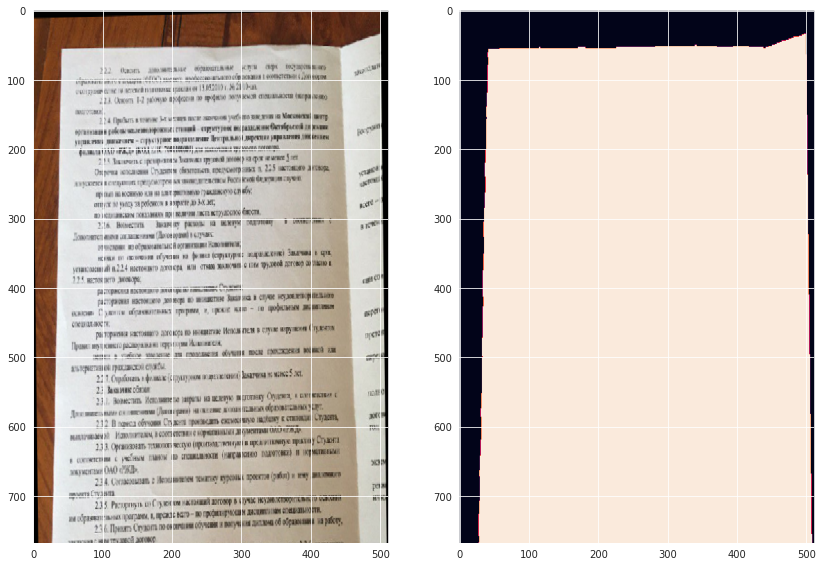

In [13]:
#Проверяем, работает ли самописный генератор
fig, ax = plt.subplots(1, 2) 
fig.set_figwidth(14) #Меняем шырину
fig.set_figheight(10) #Меняем высоту
ax[0].imshow(next(input_generator)[0]) #Вытаскиваем следующие элементы и отрисововаем на графике
ax[1].imshow(np.argmax(next(target_generator)[0], axis = -1))
plt.show()

## Модели

In [ ]:
def fillhole(input_image):
    '''
    input gray binary image  get the filled image by floodfill method
    Note: only holes surrounded in the connected regions will be filled.
    :param input_image:
    :return:
    '''
    im_flood_fill = input_image.copy()
    h, w = input_image.shape[:2]
    mask = np.zeros((h + 2, w + 2), np.uint8)
    im_flood_fill = im_flood_fill.astype("uint8")
    cv.floodFill(im_flood_fill, mask, (0, 0), 255)
    im_flood_fill_inv = cv.bitwise_not(im_flood_fill)
    img_out = input_image | im_flood_fill_inv
    return img_out

In [ ]:
# Функция визуализации сегментированных изображений
def processImage(model, count = 1, n_classes = 2):
  indexes = np.random.randint(0, len(xVal), count) # Получаем count случайных индексов
  fig, axs = plt.subplots(3, count, figsize=(25, 15)) #Создаем полотно из n графиков
  for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
    predict = np.array(model.predict(xVal[idx].reshape(1, img_width, img_height, 3))) # Предиктим картику
    pr = predict[0] # Берем нулевой элемент из перидкта
    pr1 = [] # Пустой лист под сегментированную картинку из predicta
    pr2 = [] # Пустой лист под сегменитрованную картинку из yVal
    pr = pr.reshape(-1, n_classes) # Решейпим предикт
    yr = yVal[idx].reshape(-1, n_classes) # Решейпим yVal
    for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
      pr1.append(index2color(pr[k])) # Переводим индекс в писксель
      pr2.append(index2color(yr[k])) # Переводим индекс в писксель
    pr1 = np.array(pr1) # Преобразуем в numpy
    pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    pr2 = np.array(pr2) # Преобразуем в numpy
    pr2 = pr2.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
    
    axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
    axs[0,i].axis('off')
    axs[1,i].imshow(Image.fromarray(pr2.astype('uint8'))) # Отображаем на графике во второй линии сегментированное изображение из yVal
    axs[1,i].axis('off')
    axs[2,i].imshow(Image.fromarray(xVal[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение        
    axs[2,i].axis('off')
  plt.show()  

### U-net

In [ ]:
'''
  Собственная функция метрики, обрабатывающая пересечение двух областей
'''
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

In [ ]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unetWithMask(num_classes = num_classes, input_shape = (img_width, img_height, 3)):
    img_input = Input(input_shape)                                      # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(16, (9, 9), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    x = Conv2D(16, (9, 9), padding='same', name='block1_conv2')(x)      # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_1_out = Activation('elu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_1_out
    
    block_1_out_mask = Conv2D(16, (1, 1), padding='same', activation = 'elu')(block_1_out)  # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_1_out_mask

    x = Conv2D(32, (8, 8), strides = (2, 2), padding = 'same', activation = 'elu')(block_1_out) # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(32, (8, 8), padding='same', name='block2_conv1')(x)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x) # Добавляем слой Activation

    x = Conv2D(32, (8, 8), padding='same', name='block2_conv2')(x)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_2_out = Activation('elu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_2_out

    block_2_out_mask = Conv2D(32, (1, 1), padding='same', activation = 'elu')(block_2_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_2_out_mask
    
    x = Conv2D(64, (7, 7), strides = (2, 2), padding = 'same', activation = 'elu')(block_2_out)                                     # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(64, (7, 7), padding='same', name='block3_conv1')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    x = Conv2D(64, (7, 7), padding='same', name='block3_conv2')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    x = Conv2D(64, (7, 7), padding='same', name='block3_conv3')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_3_out = Activation('elu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_3_out

    block_3_out_mask = Conv2D(64, (1, 1), padding='same', activation = 'elu')(block_3_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_3_out_mask
        
    x = Conv2D(96, (6, 6), strides = (2, 2), padding = 'same', activation = 'elu')(block_3_out)                                     # Добавляем слой MaxPooling2D

     # Block 4
    x = Conv2D(96, (6, 6), padding='same', name='block4_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    x = Conv2D(96, (6, 6), padding='same', name='block4_conv2')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    x = Conv2D(96, (6, 6), padding='same', name='block4_conv3')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_4_out = Activation('elu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_4_out

    block_4_out_mask = Conv2D(96, (1, 1), padding='same', activation = 'elu')(block_4_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_4_out_mask
            
    x = Conv2D(128, (5, 5), strides = (2, 2), padding = 'same', activation = 'elu')(block_4_out)                                     # Добавляем слой MaxPooling2D

    # Block 5
    x = Conv2D(128, (5, 5), padding='same', name='block5_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    x = Conv2D(128, (5, 5), padding='same', name='block5_conv2')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    x = Conv2D(128, (5, 5), padding='same', name='block5_conv3')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_5_out = Activation('elu')(x)                                 # Добавляем слой Activation

    block_5_out_mask = Conv2D(128, (1, 1), padding='same', activation = 'elu')(block_5_out)

    x = Conv2D(148, (4, 4), strides = (2, 2), padding = 'same', activation = 'elu')(block_5_out)

    #Block 6
    x = Conv2D(148, (4, 4), padding='same', name='block6_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    x = Conv2D(148, (4, 4), padding='same', name='block6_conv2')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    x = Conv2D(148, (4, 4), padding='same', name='block6_conv3')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_6_out = Activation('elu')(x)                                 # Добавляем слой Activation

    block_6_out_mask = Conv2D(148, (1, 1), padding='same', activation = 'elu')(block_6_out)

    x = Conv2D(192, (4, 4), strides = (2, 2), padding = 'same', activation = 'elu')(block_6_out)

    #Block 7
    x = Conv2D(192, (3, 3), padding='same', name='block7_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    x = Conv2D(192, (3, 3), padding='same', name='block7_conv2')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    x = Conv2D(192, (3, 3), padding='same', name='block7_conv3')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_7_out = Activation('elu')(x)                                 # Добавляем слой Activation

    block_7_out_mask = Conv2D(192, (1, 1), padding='same', activation = 'elu')(block_7_out)

    x = Conv2D(256, (3, 3), strides = (2, 2), padding = 'same', activation = 'elu')(block_7_out)

    #Block 8
    x = Conv2D(256, (3, 3), padding='same', name='block8_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block8_conv2')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block8_conv3')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)
    x = Conv2D(256, (1, 1), padding='same')(x)


    # UP 1
    x = Conv2DTranspose(192, (3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_7_out, block_7_out_mask])                 # Объединем текущий слой со слоем block_4_out и слоем-маской block_4_out_mask
    x = Conv2D(192, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    x = Conv2D(192, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)    
    

    # UP 2
    x = Conv2DTranspose(148, (4, 4), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_6_out, block_6_out_mask])                 # Объединем текущий слой со слоем block_4_out и слоем-маской block_4_out_mask
    x = Conv2D(148, (4, 4), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    x = Conv2D(148, (4, 4), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)    

    # UP 3
    x = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_5_out, block_5_out_mask])                 # Объединем текущий слой со слоем block_4_out и слоем-маской block_4_out_mask
    x = Conv2D(128, (5, 5), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    x = Conv2D(128, (5, 5), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)    
    
 
    # UP 4
    x = Conv2DTranspose(96, (6, 6), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_4_out, block_4_out_mask])                 # Объединем текущий слой со слоем block_4_out и слоем-маской block_4_out_mask
    x = Conv2D(96, (6, 6), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    x = Conv2D(96, (6, 6), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    # UP 5
    x = Conv2DTranspose(64, (7, 7), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_3_out, block_3_out_mask])                 # Объединем текущий слой со слоем block_3_out и слоем-маской block_3_out_mask
    x = Conv2D(64, (7, 7), padding='same')(x)                          # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    x = Conv2D(64, (7, 7), padding='same')(x)                          # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    # UP 6
    x = Conv2DTranspose(32, (8, 8), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_2_out, block_2_out_mask])                 # Объединем текущий слой со слоем block_2_out и слоем-маской block_2_out_mask
    x = Conv2D(32, (8, 8), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    x = Conv2D(32, (8, 8), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                           # Добавляем слой Activation

    # UP 7
    x = Conv2DTranspose(16, (9, 9), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                          # Добавляем слой Activation

    x = concatenate([x, block_1_out, block_1_out_mask])                # Объединем текущий слой со слоем block_1_out и слоем-маской block_1_out_mask
    x = Conv2D(16, (9, 9), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                          # Добавляем слой Activation

    x = Conv2D(16, (9, 9), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    inputmask = Conv2D(16, (9, 9), activation = 'elu', padding='same')(img_input)
    x = Concatenate()([x, inputmask])
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('elu')(x)                                          # Добавляем слой Activation

    x = Conv2D(num_classes, (9, 9), activation='softmax', padding='same')(x) # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x)                                        # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(lr = 0.0001),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model                                                       # Возвращаем сформированную модель

In [ ]:
modelM3 = unetWithMask(num_classes, (img_width, img_height, 3))
modelM3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 768, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 768, 512, 16) 3904        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_129 (BatchN (None, 768, 512, 16) 64          block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_129 (Activation)     (None, 768, 512, 16) 0           batch_normalization_129[0][0]    
____________________________________________________________________________________________

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
cb = ModelCheckpoint(
    '/content/drive/My Drive/segmentation/weightsUS/',
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    save_freq="epoch",
    options=None
)


#modelM3 = load_model('/content/drive/My Drive/segmentation/weightsUS/model100M_backup.h5')
modelM3.compile(optimizer=Adam(lr = 0.00001), loss='categorical_crossentropy', metrics=[dice_coef])
#history = modelM3.fit(xTrain/255, yTrain, epochs=100, batch_size = 2, validation_data = (xVal/255, yVal), callbacks = [cb]) #  Обучаем модель на выборке по трем классам на полноразмерных изображениях
history = modelM3.fit(train_generator, steps_per_epoch=50, epochs=200, validation_data = (xVal/255, yVal), batch_size = 2, callbacks = [cb]) #  Обучаем модель на выборке по трем классам на полноразмерных изображениях

Epoch 1/200
50/50 [==============================] - 31s 544ms/step - loss: 0.0855 - dice_coef: 0.9264 - val_loss: 0.1500 - val_dice_coef: 0.9047

Epoch 00001: val_loss improved from inf to 0.15004, saving model to /content/drive/My Drive/segmentation/weightsUS/
Epoch 2/200
50/50 [==============================] - 26s 529ms/step - loss: 0.0659 - dice_coef: 0.9345 - val_loss: 0.1506 - val_dice_coef: 0.9080

Epoch 00002: val_loss did not improve from 0.15004
Epoch 3/200
50/50 [==============================] - 26s 529ms/step - loss: 0.0877 - dice_coef: 0.9263 - val_loss: 0.1520 - val_dice_coef: 0.9075

Epoch 00003: val_loss did not improve from 0.15004
Epoch 4/200
50/50 [==============================] - 26s 528ms/step - loss: 0.0674 - dice_coef: 0.9389 - val_loss: 0.1485 - val_dice_coef: 0.9111

Epoch 00004: val_loss improved from 0.15004 to 0.14853, saving model to /content/drive/My Drive/segmentation/weightsUS/
Epoch 5/200
50/50 [==============================] - 26s 530ms/step - loss

In [ ]:
modelM3.compile(optimizer=Adam(lr = 0.00002), loss='categorical_crossentropy', metrics = ['accuracy'])
#save_model(modelM3, directory + "weightsUS/acc09811.h5")

#### Распознавание

In [ ]:
#modelM3 = load_model('/content/drive/My Drive/segmentation/weightsUS/model100Melu.h5')

In [ ]:
predictions = modelM3.predict(xVal/255, batch_size = 2)

for i, pred_image in tqdm.tqdm(enumerate(predictions)):
  actual_image = xVal[i]
  pred = index2color(pred_image, actual_image, final_mode = True).astype(np.uint8)
  pred = Image.fromarray(pred)
  pred.save(directory + f"predicted/final_results/дог{i}.jpg")

24it [00:39,  1.64s/it]


# ResNet

In [ ]:
def reslayer(*args, x, n = 4, **kwargs):
  y = Conv2D(padding = 'same', *args, **kwargs)(x)
  z = y
  for i in range(n):
    y = Conv2D(padding = 'same', *args, **kwargs)(y)
    y = BatchNormalization()(y)
    y = tf.keras.layers.LeakyReLU(alpha=0.4)(y)
  try:
    y = Add()([x, y]) #Conv-Dense model
  except: y = Add()([z, y])
  return y

def ResSimple(num_classes = num_classes, input_shape = (img_width, img_height, 3)):
  img_input = Input(input_shape)
  x = reslayer(128, (3, 3), x = img_input, n = 10)
  output = Conv2D(num_classes, (3, 3), padding = 'same', activation = 'softmax')(x)

  resnet_model = Model(img_input, output)
  resnet_model.compile(optimizer = Adam(lr = 5e-4), loss = 'categorical_crossentropy', metrics = [dice_coef])
  return resnet_model

In [ ]:
resnet_model = ResSimple()
resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 768, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 768, 512, 128 3584        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 768, 512, 128 147584      conv2d_12[0][0]                  
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 768, 512, 128 512         conv2d_13[0][0]                  
____________________________________________________________________________________________

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
cb = ModelCheckpoint(
    '/content/drive/My Drive/segmentation/weightsRes/',
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    save_freq="epoch",
    options=None
)

history = resnet_model.fit(train_generator, epochs=20, steps_per_epoch = 20, batch_size=2, validation_data = (val_generator), validation_steps = 5, callbacks = [cb]) #  Обучаем модель на выборке по трем классам на полноразмерных изображениях

Epoch 1/20
20/20 [==============================] - 52s 3s/step - loss: 0.2186 - dice_coef: 0.8840 - val_loss: 0.3290 - val_dice_coef: 0.8828

Epoch 00001: val_loss improved from inf to 0.32903, saving model to /content/drive/My Drive/segmentation/weightsRes/
Epoch 2/20
20/20 [==============================] - 52s 3s/step - loss: 0.1631 - dice_coef: 0.8907 - val_loss: 0.2878 - val_dice_coef: 0.8953

Epoch 00002: val_loss improved from 0.32903 to 0.28778, saving model to /content/drive/My Drive/segmentation/weightsRes/
Epoch 3/20
20/20 [==============================] - 52s 3s/step - loss: 0.1842 - dice_coef: 0.8979 - val_loss: 0.3751 - val_dice_coef: 0.8871

Epoch 00003: val_loss did not improve from 0.28778
Epoch 4/20
20/20 [==============================] - 52s 3s/step - loss: 0.1572 - dice_coef: 0.9045 - val_loss: 0.2287 - val_dice_coef: 0.8791

Epoch 00004: val_loss improved from 0.28778 to 0.22867, saving model to /content/drive/My Drive/segmentation/weightsRes/
Epoch 5/20
20/20 [

In [ ]:
resnet_model.save_weights('/content/drive/My Drive/segmentation/weightsRes/model_resnet.h5')

In [ ]:
resnet_model = ResSimple()
resnet_model.load_weights('/content/drive/My Drive/segmentation/weightsRes/model_resnet.h5')

In [ ]:
predictions = resnet_model.predict(xVal, batch_size = 2)

for i, pred_image in enumerate(predictions):
  actual_image = xVal[i]
  pred = index2color(pred_image, actual_image).astype(np.uint8)
  pred = Image.fromarray(pred)
  pred.save(directory + f"predicted/RESnet/дог{i}.jpg")

# PSPNet

In [ ]:
def PSPNet(num_classes = num_classes, input_shape = (img_width, img_height, 3)):
    img_input = Input(input_shape)
    start = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(img_input)

    factor1 = 2
    factor2 = 4
    factor3 = 8
    factor4 = 16
    factor5 = 32

    branch1 = Conv2D(32, (3, 3), strides = (2, 2), activation = 'relu', padding = 'same')(start)
    branch1 = Conv2DTranspose(64, (3, 3), strides = (2, 2), activation = 'relu', padding = 'same')(branch1)

    branch2 = Conv2D(64, (3, 3), strides = (2, 2), padding = 'same', activation = 'relu')(start)
    branch2 = Conv2D(128, (3, 3), strides = (2, 2), padding = 'same', activation = 'relu')(branch2)
    branch2 = Conv2DTranspose(128, (3, 3), strides = (2, 2), activation = 'relu', padding = 'same')(branch2)
    branch2 = Conv2DTranspose(64, (3, 3), strides = (2, 2), activation = 'relu', padding = 'same')(branch2)

    branch3 = Conv2D(64, (3, 3), strides = (2, 2), padding = 'same', activation = 'relu')(start)
    branch3 = Conv2D(128, (3, 3), strides = (2, 2), padding = 'same', activation = 'relu')(branch3)
    branch3 = Conv2D(256, (3, 3), strides = (2, 2), padding = 'same', activation = 'relu')(branch3)
    branch3 = Conv2DTranspose(256, (3, 3), strides = (2, 2), activation = 'relu', padding = 'same')(branch3)
    branch3 = Conv2DTranspose(128, (3, 3), strides = (2, 2), activation = 'relu', padding = 'same')(branch3)
    branch3 = Conv2DTranspose(64, (3, 3), strides = (2, 2), activation = 'relu', padding = 'same')(branch3)

    branch4 = Conv2D(64, (3, 3), strides = (2, 2), padding = 'same', activation = 'relu')(start)
    branch4 = Conv2D(128, (3, 3), strides = (2, 2), padding = 'same', activation = 'relu')(branch4)
    branch4 = Conv2D(256, (3, 3), strides = (2, 2), padding = 'same', activation = 'relu')(branch4)
    branch4 = Conv2D(512, (3, 3), strides = (2, 2), padding = 'same', activation = 'relu')(branch4)
    branch4 = Conv2DTranspose(512, (3, 3), strides = (2, 2), activation = 'relu', padding = 'same')(branch4)
    branch4 = Conv2DTranspose(256, (3, 3), strides = (2, 2), activation = 'relu', padding = 'same')(branch4)
    branch4 = Conv2DTranspose(128, (3, 3), strides = (2, 2), activation = 'relu', padding = 'same')(branch4)
    branch4 = Conv2DTranspose(64, (3, 3), strides = (2, 2), activation = 'relu', padding = 'same')(branch4)

    branch5 = Conv2D(64, (3, 3), strides = (2, 2), padding = 'same', activation = 'relu')(start)
    branch5 = Conv2D(128, (3, 3), strides = (2, 2), padding = 'same', activation = 'relu')(branch5)
    branch5 = Conv2D(256, (3, 3), strides = (2, 2), padding = 'same', activation = 'relu')(branch5)
    branch5 = Conv2D(512, (3, 3), strides = (2, 2), padding = 'same', activation = 'relu')(branch5)
    branch5 = Conv2D(768, (3, 3), strides = (2, 2), padding = 'same', activation = 'relu')(branch5)
    branch5 = Conv2DTranspose(768, (3, 3), strides = (2, 2), activation = 'relu', padding = 'same')(branch5)
    branch5 = Conv2DTranspose(512, (3, 3), strides = (2, 2), activation = 'relu', padding = 'same')(branch5)
    branch5 = Conv2DTranspose(256, (3, 3), strides = (2, 2), activation = 'relu', padding = 'same')(branch5)
    branch5 = Conv2DTranspose(128, (3, 3), strides = (2, 2), activation = 'relu', padding = 'same')(branch5)
    branch5 = Conv2DTranspose(64, (3, 3), strides = (2, 2), activation = 'relu', padding = 'same')(branch5)

    end = concatenate([branch1, branch2, branch3, branch4, branch5])
    final = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(end)
    final_2 = Add()([start, final])
    output = Conv2D(num_classes, (3, 3), padding = 'same', activation = 'sigmoid')(final_2)
    psp_net = Model(img_input, output)

    psp_net.compile(optimizer=Adam(lr = 0.0005),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return psp_net

In [ ]:
psp_net = PSPNet()
psp_net.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 512, 768, 3) 0                                            
__________________________________________________________________________________________________
conv2d_88 (Conv2D)              (None, 512, 768, 32) 896         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_99 (Conv2D)              (None, 256, 384, 64) 18496       conv2d_88[0][0]                  
__________________________________________________________________________________________________
conv2d_100 (Conv2D)             (None, 128, 192, 128 73856       conv2d_99[0][0]                  
____________________________________________________________________________________________

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
cb = ModelCheckpoint(
    '/content/drive/My Drive/segmentation/weightsPSP/',
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    save_freq="epoch",
    options=None
)

history = psp_net.fit(xTrain, yTrain, epochs=60, batch_size=2, validation_data = (xVal, yVal), callbacks = [cb]) #  Обучаем модель на выборке по трем классам на полноразмерных изображениях

Epoch 1/60
112/112 [==============================] - 54s 460ms/step - loss: 4.3397 - dice_coef: 0.7121 - val_loss: 0.6488 - val_dice_coef: 0.6833

Epoch 00001: val_loss improved from inf to 0.64884, saving model to /content/drive/My Drive/segmentation/weightsPSP/
Epoch 2/60
112/112 [==============================] - 51s 454ms/step - loss: 0.6436 - dice_coef: 0.7070 - val_loss: 0.4304 - val_dice_coef: 0.6658

Epoch 00002: val_loss improved from 0.64884 to 0.43043, saving model to /content/drive/My Drive/segmentation/weightsPSP/
Epoch 3/60
112/112 [==============================] - 51s 454ms/step - loss: 0.3368 - dice_coef: 0.6897 - val_loss: 0.3713 - val_dice_coef: 0.6885

Epoch 00003: val_loss improved from 0.43043 to 0.37127, saving model to /content/drive/My Drive/segmentation/weightsPSP/
Epoch 4/60
112/112 [==============================] - 51s 454ms/step - loss: 0.4566 - dice_coef: 0.7207 - val_loss: 0.3590 - val_dice_coef: 0.6778

Epoch 00004: val_loss improved from 0.37127 to 0.

In [ ]:
psp_net.save_weights('/content/drive/My Drive/segmentation/weightsPSP/model_resnet.h5')

In [ ]:
psp_net = PSPNet()
psp_net.load_weights('/content/drive/My Drive/segmentation/weightsPSP/model_resnet.h5')

In [ ]:
predictions = psp_net.predict(xVal, batch_size = 2)

for i, pred_image in enumerate(predictions):
  actual_image = xVal[i]
  pred = index2color(pred_image, actual_image).astype(np.uint8)
  pred = Image.fromarray(pred)
  pred.save(directory + f"predicted/PSP/дог{i}.jpg")